In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.datasets import mnist # type: ignore

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()  
X_train, X_test = X_train / 255.0, X_test / 255.0 


In [3]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))


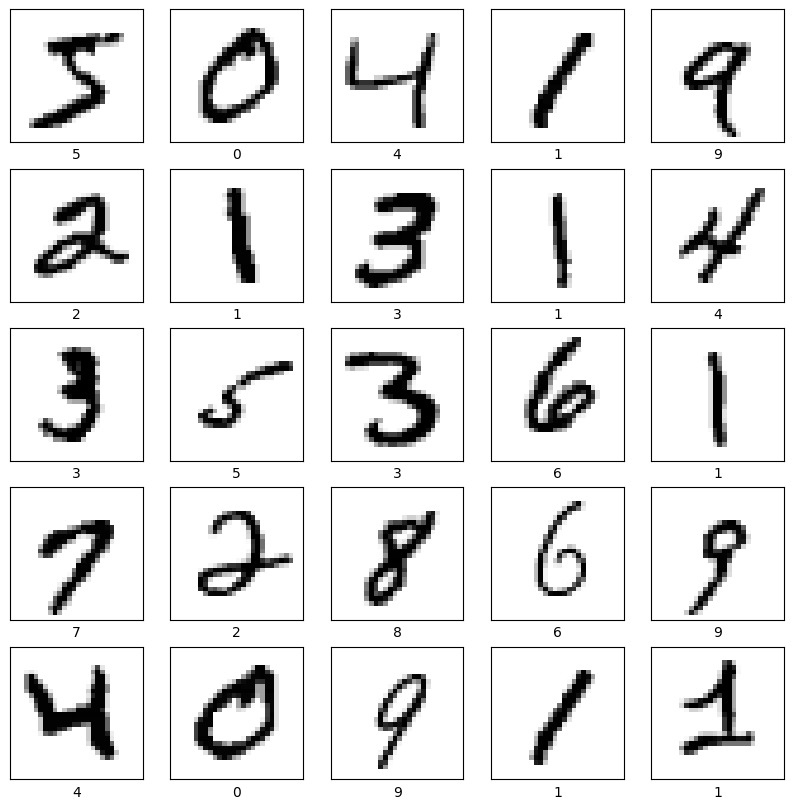

In [4]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [5]:
class NeuralNetwork:
  """
  A class representing a simple neural network.

  Parameters:
  - input_size (int): The number of input features.
  - hidden_size (int): The number of neurons in the hidden layer.
  - output_size (int): The number of output classes.

  Attributes:
  - input_size (int): The number of input features.
  - hidden_size (int): The number of neurons in the hidden layer.
  - output_size (int): The number of output classes.
  - W1 (ndarray): The weight matrix connecting the input layer to the hidden layer.
  - b1 (ndarray): The bias vector for the hidden layer.
  - W2 (ndarray): The weight matrix connecting the hidden layer to the output layer.
  - b2 (ndarray): The bias vector for the output layer.

  Methods:
  - forward(X): Performs forward propagation and returns the predicted probabilities.
  - backward(X, y, learning_rate): Performs backward propagation and updates the weights and biases.
  - train(X, y, learning_rate, epochs): Trains the neural network using the given data.
  - predict(X): Predicts the class labels for the given input data.

  """

  def __init__(self, input_size, hidden_size, output_size):
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.W1 = np.random.randn(self.input_size, self.hidden_size)  # weights
    self.b1 = np.zeros((1, self.hidden_size)) # biases
    self.W2 = np.random.randn(self.hidden_size, self.output_size) # weights
    self.b2 = np.zeros((1, self.output_size)) # biases


  def forward(self, X):
    """
    Performs forward propagation and returns the predicted probabilities.

    Parameters:
    - X (ndarray): The input data of shape (num_samples, input_size).

    Returns:
    - ndarray: The predicted probabilities of shape (num_samples, output_size).

    """
    self.z1 = np.dot(X, self.W1) + self.b1  # z1 = XW1 + b1
    self.a1 = np.maximum(0, self.z1) # a1 = ReLU(z1)
    self.z2 = np.dot(self.a1, self.W2) + self.b2 # z2 = a1W2 + b2
    # Subtracting the maximum value
    exp_scores = np.exp(self.z2 - np.max(self.z2, axis=1, keepdims=True))  
    self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # softmax activation
    return self.probs


  def backward(self, X, y, learning_rate):
    """
    Performs backward propagation and updates the weights and biases.

    Parameters:
    - X (ndarray): The input data of shape (num_samples, input_size).
    - y (ndarray): The true labels of shape (num_samples,).
    - learning_rate (float): The learning rate for updating the weights and biases.

    """
    m = X.shape[0] # number of samples
    delta3 = self.probs # predicted probabilities
    delta3[range(m), y] -= 1 # y_hat - y
    delta3 /= m # average over samples

    dW2 = np.dot(self.a1.T, delta3) # gradient of W2, equation = a1.T * delta3 
    db2 = np.sum(delta3, axis=0, keepdims=True) # gradient of b2, equation = sum(delta3)

    delta2 = np.dot(delta3, self.W2.T) # gradient of a1, equation = delta3 * W2.T
    delta2[self.a1 <= 0] = 0 # gradient of ReLU, equation = delta2 * ReLU'(z1)

    dW1 = np.dot(X.T, delta2) # gradient of W1, equation = X.T * delta2
    db1 = np.sum(delta2, axis=0) # gradient of b1, equation = sum(delta2)

    self.W1 -= learning_rate * dW1 # update W1
    self.b1 -= learning_rate * db1 # update b1
    self.W2 -= learning_rate * dW2 # update W2
    self.b2 -= learning_rate * db2 # update b2

  def train(self, X, y, X_val, y_val, learning_rate, epochs): # training and output each epoch
    """
    Trains the neural network using the given data.

    Parameters:
    - X (ndarray): The input data of shape (num_samples, input_size).
    - y (ndarray): The true labels of shape (num_samples,).
    - X_val (ndarray): The validation input data of shape (num_samples, input_size).
    - y_val (ndarray): The true labels of the validation set.
    - learning_rate (float): The learning rate for updating the weights and biases.
    - epochs (int): The number of training epochs.

    """
    for epoch in range(epochs):
      self.forward(X)
      self.backward(X, y, learning_rate)
      
      train_loss, train_accuracy = self.evaluate(X, y)
      
      
      val_loss, val_accuracy = self.evaluate(X_val, y_val)
      
      
      print(f'Epoch {epoch+1}/{epochs} - '
            f'loss: {train_loss:.4f} - accuracy: {train_accuracy:.4f} - '
            f'val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}')

  def evaluate(self, X, y):
    """
    Evaluates the model on the given data.

    Parameters:
    - X (ndarray): The input data of shape (num_samples, input_size).
    - y (ndarray): The true labels of shape (num_samples,).

    Returns:
    - tuple: A tuple containing the loss and accuracy.
    """
    
    probs = self.forward(X) # predicted probabilities
    
    
    m = X.shape[0] # number of samples
    eps = 1e-10  # small epsilon value to avoid zero probability
    loss = -np.log(probs[range(m), y] + eps).sum() / m # cross-entropy loss
    
    predictions = np.argmax(probs, axis=1) # predicted class labels
    accuracy = np.mean(predictions == y) # accuracy
    
    return loss, accuracy


  def predict(self, X):
    """
    Predicts the class labels for the given input data.

    Parameters:
    - X (ndarray): The input data of shape (num_samples, input_size).

    Returns:
    - ndarray: The predicted class labels of shape (num_samples,).

    """
    return np.argmax(self.forward(X), axis=1)


In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [18]:
input_size = 784
hidden_size = input_size * 2
output_size = 10
learning_rate = 0.7
epochs = 200

model = NeuralNetwork(input_size, hidden_size, output_size)

model.train(X_train, y_train, X_val, y_val, learning_rate, epochs)

train_loss, train_accuracy = model.evaluate(X_train, y_train)
val_loss, val_accuracy = model.evaluate(X_val, y_val)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/200 - loss: 18.9338 - accuracy: 0.1766 - val_loss: 18.8953 - val_accuracy: 0.1784
Epoch 2/200 - loss: 13.5414 - accuracy: 0.4072 - val_loss: 13.4858 - val_accuracy: 0.4093
Epoch 3/200 - loss: 13.1745 - accuracy: 0.4230 - val_loss: 12.9509 - val_accuracy: 0.4335
Epoch 4/200 - loss: 11.1266 - accuracy: 0.5010 - val_loss: 11.0937 - val_accuracy: 0.5036
Epoch 5/200 - loss: 9.4713 - accuracy: 0.5637 - val_loss: 9.2260 - val_accuracy: 0.5751
Epoch 6/200 - loss: 5.3361 - accuracy: 0.7316 - val_loss: 5.1418 - val_accuracy: 0.7410
Epoch 7/200 - loss: 4.1894 - accuracy: 0.7823 - val_loss: 4.0401 - val_accuracy: 0.7920
Epoch 8/200 - loss: 3.8558 - accuracy: 0.7958 - val_loss: 3.7320 - val_accuracy: 0.8076
Epoch 9/200 - loss: 3.6132 - accuracy: 0.8065 - val_loss: 3.5385 - val_accuracy: 0.8161
Epoch 10/200 - loss: 3.4381 - accuracy: 0.8141 - val_loss: 3.4123 - val_accuracy: 0.8219
Epoch 11/200 - loss: 3.2947 - accuracy: 0.8202 - val_loss: 3.3028 - val_accuracy: 0.8246
Epoch 12/200 - loss: 3

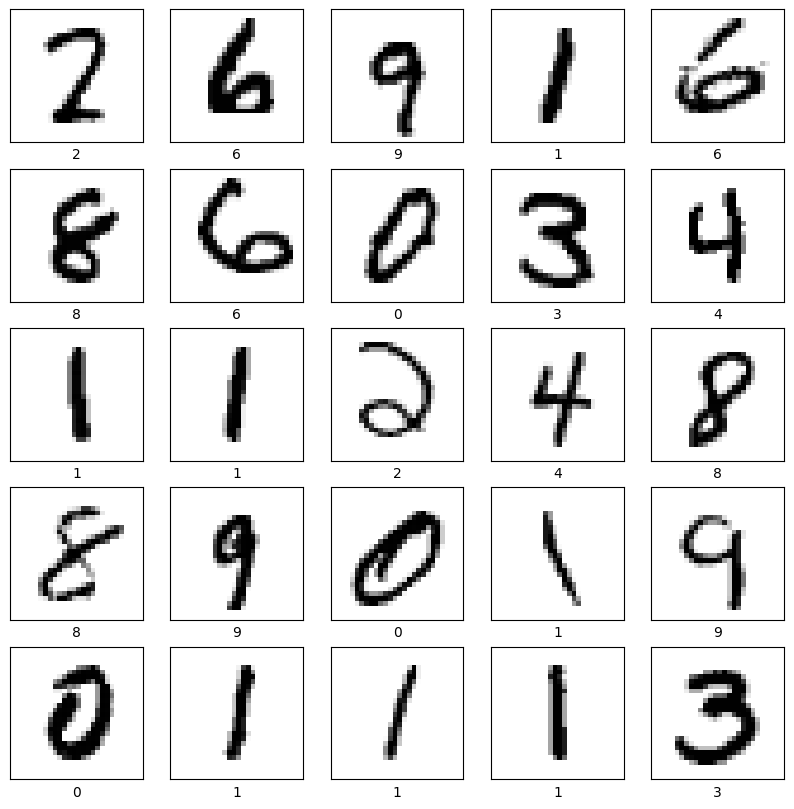

In [26]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

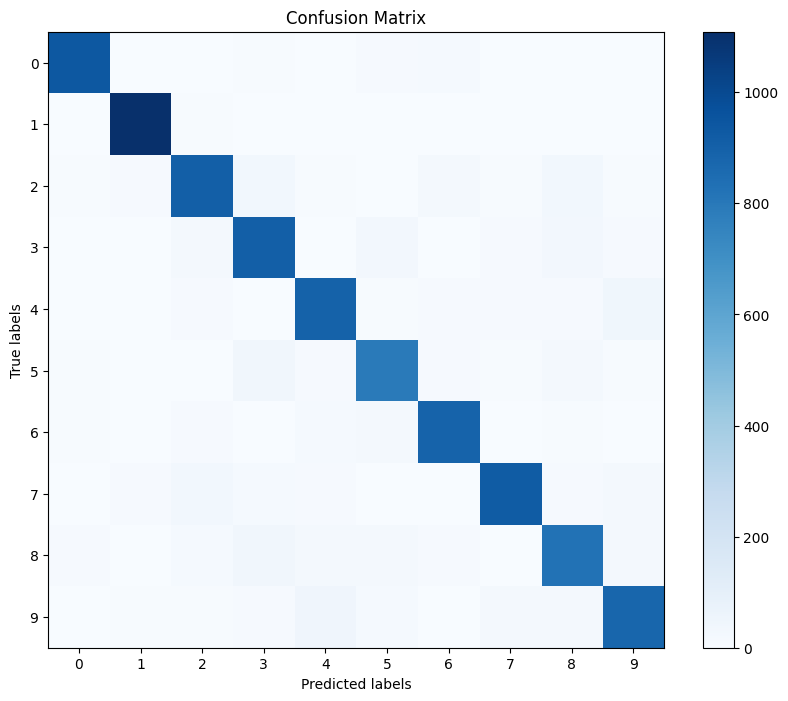

In [27]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, model.predict(X_test))
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.title('Confusion Matrix')
plt.show()